[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/combine-org/combine-notebooks/main?labpath=notebooks%2Fneuroml.ipynb)
<a href="https://colab.research.google.com/github/combine-org/combine-notebooks/blob/main/notebooks/neuroml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab\"/></a>

# Simple NeuroML example

This notebook creates a simple model in [NeuroML version 2](https://docs.neuroml.org/Userdocs/NeuroMLv2.html). It adds a [simple spiking neuron model](https://docs.neuroml.org/Userdocs/Schemas/Cells.html#schema-izhikevich2007cell) to a [population](https://docs.neuroml.org/Userdocs/Schemas/Networks.html#schema-population) and then the population to a [network](https://docs.neuroml.org/Userdocs/Schemas/Networks.html#network). Then we create a [LEMS simulation file](https://docs.neuroml.org/Userdocs/LEMSSimulation.html) to specify how to to a simulate the model, and finally we execute it using [jNeuroML](https://docs.neuroml.org/Userdocs/Software/jNeuroML.html#jneuroml).  The results of that simulation are plotted below.

<center>
<img src="./results/neuroml_plot.png" alt="NeuroML Simulation Plot">
</center>

## 1) Including libraries

Note: Please uncomment the line below if you use the Google Colab.

In [1]:
#%pip install pyneuroml

In [2]:
from neuroml import NeuroMLDocument
from pyneuroml import pynml
import neuroml.writers as writers
from neuroml.utils import validate_neuroml2
from pyneuroml.lems import LEMSSimulation

## 2) Declaring the NeuroML model

### Create a NeuroML document

This is the container document to which the cells and the network will be added. 

In [3]:
nml_doc = NeuroMLDocument(id="IzhNeuron")

### Define the Izhikevich cell and add it

The [Izhikevich model](https://www.izhikevich.org/publications/spikes.htm) is a simple, 2 variable neuron model exhibiting a range of neurophysiologically realistic spiking behaviours depending on the parameters given. We use the [izhikevich2007cell](https://docs.neuroml.org/Userdocs/Schemas/Cells.html#izhikevich2007cell) version here. 

In [4]:
izh0 = nml_doc.add(
    "Izhikevich2007Cell",
    id="izh2007RS0", v0="-60mV", C="100pF", k="0.7nS_per_mV", vr="-60mV",
    vt="-40mV", vpeak="35mV", a="0.03per_ms", b="-2nS", c="-50.0mV", d="100pA")


### Create a network and add it to the model

We add a [network](https://docs.neuroml.org/Userdocs/Schemas/Networks.html#network) to the document created above. 

In [5]:
net = nml_doc.add("Network", id="IzNet", validate=False)

### Create a population of defined cells and add it to the network

A [population](https://docs.neuroml.org/Userdocs/Schemas/Networks.html#schema-population) of size 1 of these cells is created and then added to the network. 

In [6]:

pop0 = net.add("Population", id="IzhPop0", component=izh0.id, size=1)


### Define an external stimulus and add it to the model

On its own the cell will not spike, so we add a small current to it in the form of a [pulse generator](https://docs.neuroml.org/Userdocs/Schemas/Inputs.html#pulsegenerator) which will apply a square pulse of current. 

In [7]:
pg = nml_doc.add(
    "PulseGenerator",
    id="pulseGen_%i" % 0, delay="100ms", duration="800ms",
    amplitude="0.07 nA"
)
exp_input = net.add("ExplicitInput", target="%s[%i]" % (pop0.id, 0), input=pg.id)

## 3) Write, print and validate the generated file 

### Write the NeuroML model to a file

In [8]:

nml_file = 'hello_world_neuroml.nml'
writers.NeuroMLWriter.write(nml_doc, nml_file)
print("Written network file to: " + nml_file)

Written network file to: hello_world_neuroml.nml


### Print out the file

Here we print the XML for the saved NeuroML file. 

In [9]:
with open(nml_file) as f: 
   print(f.read())

<neuroml xmlns="http://www.neuroml.org/schema/neuroml2"  xmlns:xs="http://www.w3.org/2001/XMLSchema" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.neuroml.org/schema/neuroml2 https://raw.github.com/NeuroML/NeuroML2/development/Schemas/NeuroML2/NeuroML_v2.3.xsd" id="IzhNeuron">
    <izhikevich2007Cell id="izh2007RS0" C="100pF" v0="-60mV" k="0.7nS_per_mV" vr="-60mV" vt="-40mV" vpeak="35mV" a="0.03per_ms" b="-2nS" c="-50.0mV" d="100pA"/>
    <pulseGenerator id="pulseGen_0" delay="100ms" duration="800ms" amplitude="0.07 nA"/>
    <network id="IzNet">
        <population id="IzhPop0" component="izh2007RS0" size="1"/>
        <explicitInput target="IzhPop0[0]" input="pulseGen_0"/>
    </network>
</neuroml>



### Validate the NeuroML model

In [ ]:
validate_neuroml2(nml_file)

It's valid!


## 4) Simulating the model

### Create a simulation instance of the model

The NeuroML file does not contain any information on how long to simulate the model for or what to save etc. For this we will need a [LEMS simulation file](https://docs.neuroml.org/Userdocs/LEMSSimulation.html).


In [ ]:
simulation_id = "example-single-izhikevich2007cell-sim"
simulation = LEMSSimulation(sim_id=simulation_id,
                            duration=1000, dt=0.1, simulation_seed=123)
simulation.assign_simulation_target(net.id)
simulation.include_neuroml2_file(nml_file)

pyNeuroML >>> INFO - Loading NeuroML2 file: /Users/padraig/git/combine-notebooks/notebooks/hello_world_neuroml.nml


### Define the output file to store simulation outputs

Here, we record the neuron's membrane potential to the specified data file.

In [ ]:
simulation.create_output_file(
    "output0", "%s.v.dat" % simulation_id
)
simulation.add_column_to_output_file("output0", 'IzhPop0[0]', 'IzhPop0[0]/v')

### Save the simulation to a file

In [ ]:
lems_simulation_file = simulation.save_to_file()
with open(lems_simulation_file) as f: 
   print(f.read())

<Lems>
    
    <!-- 

        This LEMS file has been automatically generated using PyNeuroML v1.0.0 (libNeuroML v0.5.0)

     -->
    
    <!-- Specify which component to run -->
    <Target component="example-single-izhikevich2007cell-sim"/>

    <!-- Include core NeuroML2 ComponentType definitions -->
    <Include file="Cells.xml"/>
    <Include file="Networks.xml"/>
    <Include file="Simulation.xml"/>
    
    <Include file="hello_world_neuroml.nml"/>
   
    <Simulation id="example-single-izhikevich2007cell-sim" length="1000ms" step="0.1ms" target="IzNet" seed="123">  <!-- Note seed: ensures same random numbers used every run -->
        
        <OutputFile id="output0" fileName="example-single-izhikevich2007cell-sim.v.dat">
            <OutputColumn id="IzhPop0[0]" quantity="IzhPop0[0]/v"/> 
        </OutputFile>
        
    </Simulation>

</Lems>



### Run the simulation using the jNeuroML simulator

[jNeuroML](https://docs.neuroml.org/Userdocs/Software/jNeuroML.html#jneuroml) is a simple NeuroML simulator which can quickly execute the generated model. 

In [ ]:
pynml.run_lems_with_jneuroml(
    lems_simulation_file, max_memory="2G", nogui=True, plot=False
)

pyNeuroML >>> INFO - Loading LEMS file: LEMS_example-single-izhikevich2007cell-sim.xml and running with jNeuroML
pyNeuroML >>> INFO - Executing: (java -Xmx2G  -Djava.awt.headless=true -jar  "/opt/homebrew/anaconda3/envs/py39n/lib/python3.9/site-packages/pyneuroml/lib/jNeuroML-0.12.1-jar-with-dependencies.jar"  LEMS_example-single-izhikevich2007cell-sim.xml  -nogui -I '') in directory: .
pyNeuroML >>> INFO - Command completed successfully!


True

### Plot the recorded data

pyNeuroML >>> INFO - Generating plot: Membrane potential


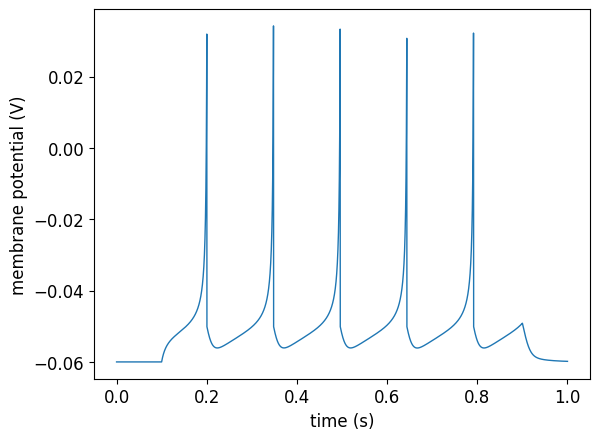

<AxesSubplot:xlabel='time (s)', ylabel='membrane potential (V)'>

In [ ]:
# Load the data from the file and plot the graph for the membrane potential
# using the pynml generate_plot utility function.

import numpy as np
data_array = np.loadtxt("%s.v.dat" % simulation_id)
pynml.generate_plot(
    [data_array[:, 0]], [data_array[:, 1]],
    "Membrane potential", show_plot_already=True,
    xaxis="time (s)", yaxis="membrane potential (V)"
)